# BSPF Analysis

In [2]:
import os
import pandas as pd
import numpy as np
import obspy as obs

import matplotlib.pyplot as plt

In [3]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [5]:
config = {}

config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_figs'] = data_path+"BSPF/figures/statistics/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = ""

config['translation_type'] = "ACC"

## Load Data

In [6]:
data_amax = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")

data_snr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")

data_adr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")

data_good = pd.read_pickle(config['path_to_catalogs']+"good_events_20221001_20230930.pkl")

In [7]:
print(f" AMAX:  all: {data_amax.origin.size} no_nan: {data_amax.origin.dropna().size}")
print(f" SNR:  all: {data_snr.origin.size} no_nan: {data_snr.origin.dropna().size}")
print(f" ADR:  all: {data_adr.origin.size} no_nan: {data_adr.origin.dropna().size}")

# data_amax = data_amax.dropna()
# data_snr = data_snr.dropna()
# data_adr = data_adr.dropna()

 AMAX:  all: 225 no_nan: 225
 SNR:  all: 225 no_nan: 225
 ADR:  all: 225 no_nan: 225


In [8]:
# data_adr.nunique()
data_adr = data_adr.dropna()

## Modify Data

Filter data for events with coincidence sum 6

In [9]:
data_amax_cosum_6 = data_amax[data_amax.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]

data_adr_cosum_6 = data_adr[data_adr.CoincidenceSum == 6]

In [10]:
print(f" AMAX:  {data_amax_cosum_6.origin.size}")
print(f" SNR:   {data_snr_cosum_6.origin.size}")
print(f" ADR:   {data_adr_cosum_6.origin.size}")

 AMAX:  131
 SNR:   131
 ADR:   130


## Plots

In [11]:
max_rot = []
for nn in range(data_amax_cosum_6.shape[0]):
    max_rot.append(np.nanmax([data_amax_cosum_6.iloc[nn].BSPF__E_amax, data_amax_cosum_6.iloc[nn].BSPF__N_amax, data_amax_cosum_6.iloc[nn].BSPF__Z_amax]))


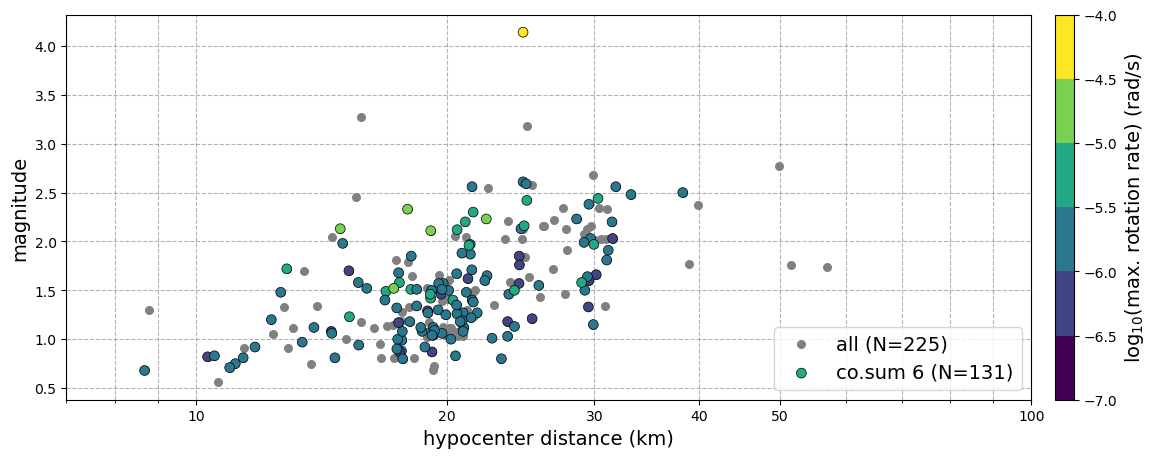

In [14]:
def __makeplot(data1, data2, data3, data4, max_rot):

    import matplotlib

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    font=14

    cmap = plt.get_cmap("viridis", 6)

    # dat = np.log10(data4.BSPF__N_snr)
    # dat = np.log10(data4.PFO_10_Z_snr)

    dat = np.log10(max_rot)

    ax.scatter(data1.Hdistance_km, data1.Magnitude, s=30, color="grey", zorder=1, label=f"all (N={len(data1)})")

    cax = ax.scatter(data2.Hdistance_km, data2.Magnitude, s=50, lw=0.5, edgecolors="k",
                     c=dat, cmap=cmap, zorder=2, label=f"co.sum 6 (N={len(data2)})", vmin=-7, vmax=-4)

    # cax = ax.scatter(data_good.Hdistance_km, data_good.Magnitude, s=50, lw=0.5, edgecolors="r",
    #                  c=dat, cmap=cmap, zorder=2, label=f"co.sum 6 (N={len(data2)})", vmin=-7, vmax=-4)


    ax.grid(ls="--", color="grey", alpha=0.6, zorder=0,which="both")
    ax.legend(loc=4, fontsize=font)

    ax.set_ylabel("magnitude", fontsize=font)
    ax.set_xlabel("hypocenter distance (km)", fontsize=font)

    ax.set_xscale("log")
    ax.set_xlim(left=7)

    cbar = plt.colorbar(cax, pad=0.02)
    cbar.set_label(r"log$_{10}$(max. rotation rate) (rad/s)", fontsize=font)
#     cbar.set_clim(0,4)

    ax.set_xticks([10, 20, 30, 40, 50, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.show()
    return fig

fig = __makeplot(data_amax, data_amax_cosum_6, data_snr, data_snr_cosum_6, max_rot)

fig.savefig(config['path_to_figs']+f"BSPF_statistics_mag_hdist.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Polar Plot

In [12]:
def __polar_plot(data1, data2):

    r1 = data1.Edistance_km
    r2 = data2.Edistance_km
    theta1 = np.radians(data1.BAZ)
    theta2 = np.radians(data2.BAZ)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    ax.scatter(theta1, r1, s=4**data1.Magnitude, c="grey", zorder=2)
    ax.scatter(theta2, r2, s=4**data2.Magnitude, lw=0.5, edgecolors="k", zorder=3)

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()
    return fig

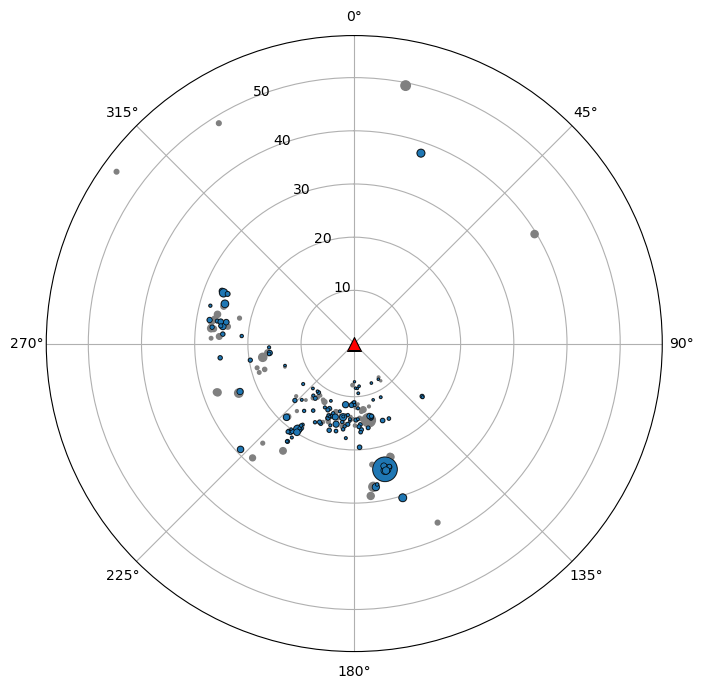

In [13]:
fig = __polar_plot(data_amax, data_amax_cosum_6)

fig.savefig(config['path_to_figs']+f"BSPF_statistics_polar.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Amplitude Maxima

In [14]:
def __makeplot_amax(data1, data2, xvalue):

    NJ = 4
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10))

    font = 14

    scale = 1
    msize = 12
    linew = 0.1

    ## _________________________

    ax[0,0].scatter(data1[xvalue], data1.PFO_10_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,0].scatter(data2[xvalue], data2.PFO_10_Z_amax*scale, s=msize, color="red", label="XPFO Z", lw=linew, edgecolors="k")

    ax[0,1].scatter(data1[xvalue], data1.PFO_10_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,1].scatter(data2[xvalue], data2.PFO_10_N_amax*scale, s=msize, color="red", label="XPFO N", lw=linew, edgecolors="k")

    ax[0,2].scatter(data1[xvalue], data1.PFO_10_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,2].scatter(data2[xvalue], data2.PFO_10_E_amax*scale, s=msize, color="red", label="XPFO E", lw=linew, edgecolors="k")

    ## _________________________

    ax[1,0].scatter(data1[xvalue], data1.RPFO_al_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,0].scatter(data2[xvalue], data2.RPFO_al_Z_amax*scale, s=msize, color="red", label="ADR all Z", lw=linew, edgecolors="k")

    ax[1,1].scatter(data1[xvalue], data1.RPFO_al_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,1].scatter(data2[xvalue], data2.RPFO_al_N_amax*scale, s=msize, color="red", label="ADR all N", lw=linew, edgecolors="k")

    ax[1,2].scatter(data1[xvalue], data1.RPFO_al_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,2].scatter(data2[xvalue], data2.RPFO_al_E_amax*scale, s=msize, color="red", label="ADR all E", lw=linew, edgecolors="k")

    ## _________________________

    ax[2,0].scatter(data1[xvalue], data1.RPFO_in_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,0].scatter(data2[xvalue], data2.RPFO_in_Z_amax*scale, s=msize, color="red", label="ADR inner Z", lw=linew, edgecolors="k")

    ax[2,1].scatter(data1[xvalue], data1.RPFO_in_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,1].scatter(data2[xvalue], data2.RPFO_in_N_amax*scale, s=msize, color="red", label="ADR inner N", lw=linew, edgecolors="k")

    ax[2,2].scatter(data1[xvalue], data1.RPFO_in_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,2].scatter(data2[xvalue], data2.RPFO_in_E_amax*scale, s=msize, color="red", label="ADR inner E", lw=linew, edgecolors="k")

    ## _________________________

    ax[3,0].scatter(data1[xvalue], data1.BSPF__Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,0].scatter(data2[xvalue], data2.BSPF__Z_amax*scale, s=msize, color="red", label="BSPF Z", lw=linew, edgecolors="k")

    ax[3,1].scatter(data1[xvalue], data1.BSPF__N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,1].scatter(data2[xvalue], data2.BSPF__N_amax*scale, s=msize, color="red", label="BSPF N", lw=linew, edgecolors="k")

    ax[3,2].scatter(data1[xvalue], data1.BSPF__E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,2].scatter(data2[xvalue], data2.BSPF__E_amax*scale, s=msize, color="red", label="BSPF E", lw=linew, edgecolors="k")



    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            # ax[i,j].set_xscale("log")
            ax[i,j].legend(loc=4)
            ax[3,j].set_xlabel(xvalue, fontsize=font)
            ax[i,j].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0,0].set_ylabel(r"Acc. (m/s$^2$)", fontsize=font)
    ax[1,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[2,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[3,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)

    plt.show()

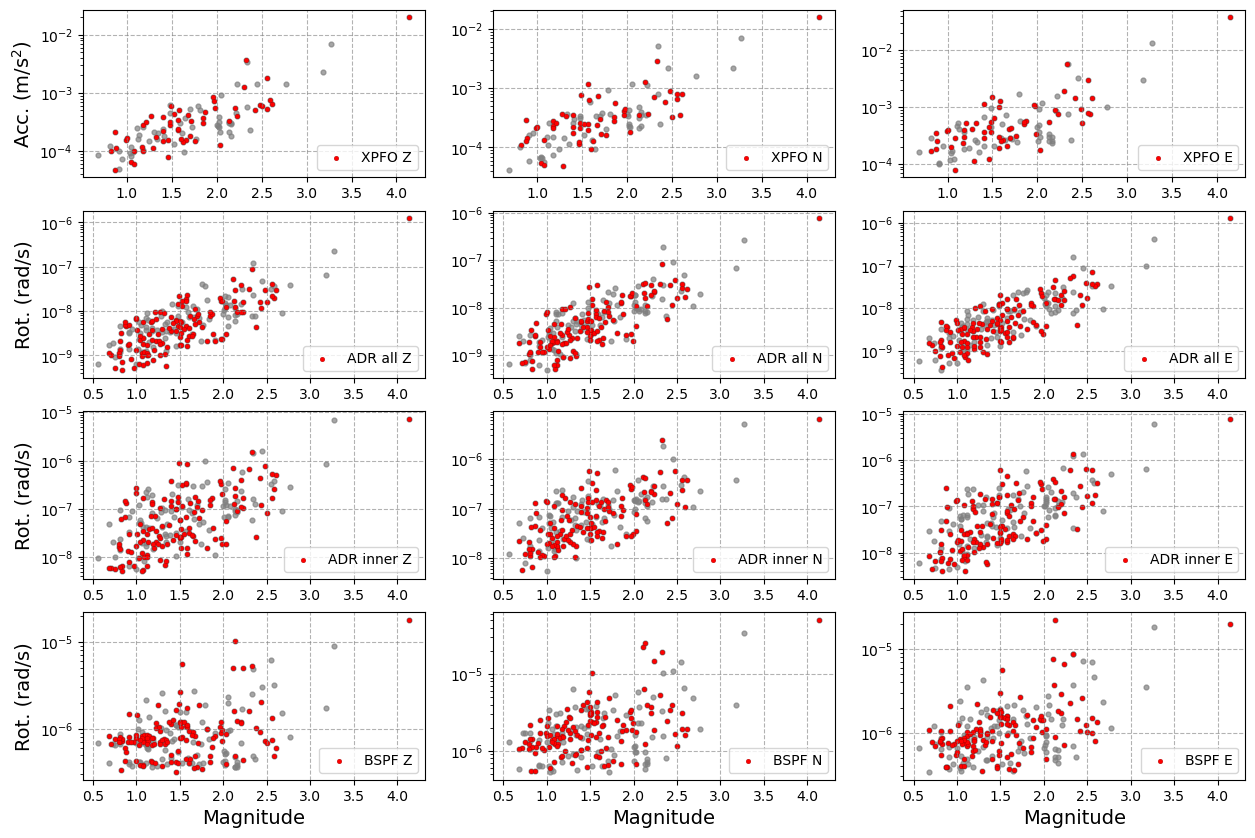

In [15]:
__makeplot_amax(data_amax, data_amax_cosum_6, "Magnitude")

fig.savefig(config['path_to_figs']+f"BSPF_statistics_ampl_mag.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

In [16]:
def __makeplot_amax2(data1, data2, xvalue):

    NJ = 4
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10))

    font = 14

    scale = 1
    msize = 12
    linew = 0.1

    ## _________________________

    ax[0,0].scatter(data1[xvalue], data1.PFO_10_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,0].scatter(data2[xvalue], data2.PFO_10_Z_amax*scale, s=msize, color="red", label="XPFO Z", lw=linew, edgecolors="k")

    ax[0,1].scatter(data1[xvalue], data1.PFO_10_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,1].scatter(data2[xvalue], data2.PFO_10_N_amax*scale, s=msize, color="red", label="XPFO N", lw=linew, edgecolors="k")

    ax[0,2].scatter(data1[xvalue], data1.PFO_10_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,2].scatter(data2[xvalue], data2.PFO_10_E_amax*scale, s=msize, color="red", label="XPFO E", lw=linew, edgecolors="k")

    ## _________________________

    ax[1,0].scatter(data1[xvalue], data1.RPFO_al_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,0].scatter(data2[xvalue], data2.RPFO_al_Z_amax*scale, s=msize, color="red", label="ADR all Z", lw=linew, edgecolors="k")

    ax[1,1].scatter(data1[xvalue], data1.RPFO_al_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,1].scatter(data2[xvalue], data2.RPFO_al_N_amax*scale, s=msize, color="red", label="ADR all N", lw=linew, edgecolors="k")

    ax[1,2].scatter(data1[xvalue], data1.RPFO_al_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,2].scatter(data2[xvalue], data2.RPFO_al_E_amax*scale, s=msize, color="red", label="ADR all E", lw=linew, edgecolors="k")

    ## _________________________

    ax[2,0].scatter(data1[xvalue], data1.RPFO_in_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,0].scatter(data2[xvalue], data2.RPFO_in_Z_amax*scale, s=msize, color="red", label="ADR inner Z", lw=linew, edgecolors="k")

    ax[2,1].scatter(data1[xvalue], data1.RPFO_in_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,1].scatter(data2[xvalue], data2.RPFO_in_N_amax*scale, s=msize, color="red", label="ADR inner N", lw=linew, edgecolors="k")

    ax[2,2].scatter(data1[xvalue], data1.RPFO_in_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,2].scatter(data2[xvalue], data2.RPFO_in_E_amax*scale, s=msize, color="red", label="ADR inner E", lw=linew, edgecolors="k")

    ## _________________________

    ax[3,0].scatter(data1[xvalue], data1.BSPF__Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,0].scatter(data2[xvalue], data2.BSPF__Z_amax*scale, s=msize, color="red", label="BSPF Z", lw=linew, edgecolors="k")

    ax[3,1].scatter(data1[xvalue], data1.BSPF__N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,1].scatter(data2[xvalue], data2.BSPF__N_amax*scale, s=msize, color="red", label="BSPF N", lw=linew, edgecolors="k")

    ax[3,2].scatter(data1[xvalue], data1.BSPF__E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,2].scatter(data2[xvalue], data2.BSPF__E_amax*scale, s=msize, color="red", label="BSPF E", lw=linew, edgecolors="k")


    # for j in range(1,3):
    #     ax[j,0].set_ylim(1e-9, 1e-5)
    #     ax[j,1].set_ylim(1e-9, 1e-5)
    #     ax[j,2].set_ylim(1e-9, 1e-5)

    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            ax[i,j].set_xscale("log")
            ax[i,j].legend(loc=1)
            ax[3,j].set_xlabel("Hypocenter Distance (km)", fontsize=font)
#             ax[i,j].grid(ls="--", color="grey", alpha=0.6, zorder=0, which="both")
            ax[i,j].set_xlim(left=10)

    ax[0,0].set_ylabel(r"Acc. (m/s$^2$)", fontsize=font)
    ax[1,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[2,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[3,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)

    plt.show()

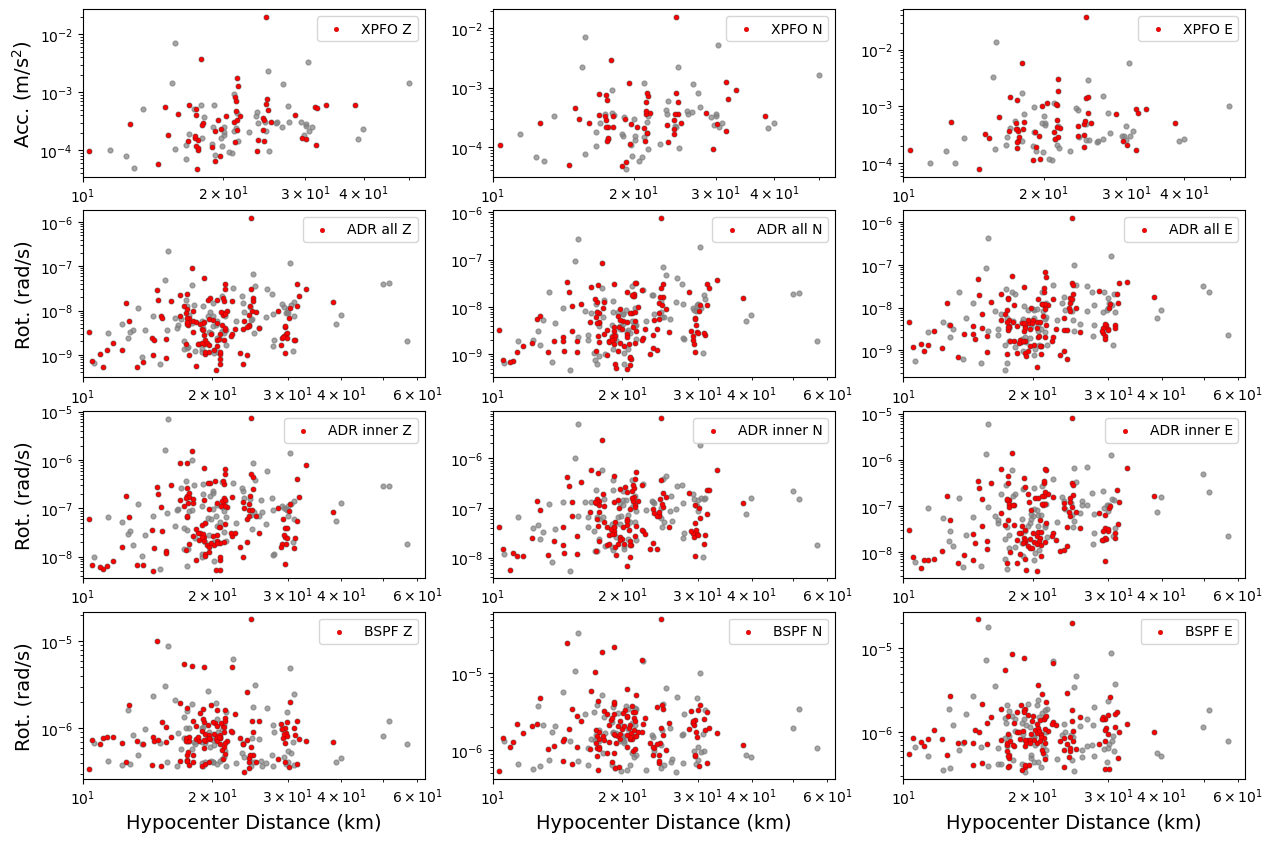

In [17]:
__makeplot_amax2(data_amax, data_amax_cosum_6, "Hdistance_km")

## Compare ADR - BSPF maximal amplitudes

In [18]:
def __makeplot_compare_amax(data1, data2):

    NJ = 3
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10), sharex=True)

    font = 14
    scale = 1
    msize = 12
    linew = 0.1




    ## _________________________


    ax[0,0].scatter(data1.BSPF_i_Z_adr, data1.RPFO_in_Z_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[0,0].scatter(data2.BSPF_i_Z_adr, data2.RPFO_in_Z_adr, s=msize, color="tab:red", label="RPFO inner Z", lw=linew, edgecolors="k", zorder=3)

    ax[0,1].scatter(data1.BSPF_i_N_adr, data1.RPFO_in_N_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[0,1].scatter(data2.BSPF_i_N_adr, data2.RPFO_in_N_adr, s=msize, color="tab:red", label="RPFO inner N", lw=linew, edgecolors="k", zorder=3)

    ax[0,2].scatter(data1.BSPF_i_E_adr, data1.RPFO_in_E_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[0,2].scatter(data2.BSPF_i_E_adr, data2.RPFO_in_E_adr, s=msize, color="tab:red", label="RPFO inner E", lw=linew, edgecolors="k", zorder=3)

    ## _________________________


    ax[1,0].scatter(data1.BSPF_m_Z_adr, data1.RPFO_mi_Z_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[1,0].scatter(data2.BSPF_m_Z_adr, data2.RPFO_mi_Z_adr, s=msize, color="tab:red", label="ADR mid Z", lw=linew, edgecolors="k", zorder=3)

    ax[1,1].scatter(data1.BSPF_m_N_adr, data1.RPFO_mi_N_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[1,1].scatter(data2.BSPF_m_N_adr, data2.RPFO_mi_N_adr, s=msize, color="tab:red", label="ADR mid N", lw=linew, edgecolors="k", zorder=3)

    ax[1,2].scatter(data1.BSPF_m_E_adr, data1.RPFO_mi_E_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[1,2].scatter(data2.BSPF_m_E_adr, data2.RPFO_mi_E_adr, s=msize, color="tab:red", label="ADR mid E", lw=linew, edgecolors="k", zorder=3)


    ## _________________________


    ax[2,0].scatter(data1.BSPF_a_Z_adr, data1.RPFO_al_Z_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[2,0].scatter(data2.BSPF_a_Z_adr, data2.RPFO_al_Z_adr, s=msize, color="tab:red", label="ADR all Z", lw=linew, edgecolors="k", zorder=3)

    ax[2,1].scatter(data1.BSPF_a_N_adr, data1.RPFO_al_N_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[2,1].scatter(data2.BSPF_a_N_adr, data2.RPFO_al_N_adr, s=msize, color="tab:red", label="ADR all N", lw=linew, edgecolors="k", zorder=3)

    ax[2,2].scatter(data1.BSPF_a_E_adr, data1.RPFO_al_E_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[2,2].scatter(data2.BSPF_a_E_adr, data2.RPFO_al_E_adr, s=msize, color="tab:red", label="ADR all E", lw=linew, edgecolors="k", zorder=3)



    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            ax[i,j].set_xscale("log")
            ax[2,j].set_xlabel(r"BSPF (rad/s)", fontsize=font)

            ax[i,j].legend(loc=2)
            ax[i,j].grid(ls="-", color="lightgrey", alpha=0.6, zorder=0, which="both")

    for j in range(NI):
        ax[0,j].set_title(f"0.16-16.5 Hz")
        ax[1,j].set_title(f"0.02-1.3 Hz")
        ax[2,j].set_title("0.03-3.3 Hz")

        # ax[0,j].set_title("5.0-16.0 Hz")
        # ax[1,j].set_title("0.5-1.0 Hz")
        # ax[2,j].set_title("0.3-3.0 Hz")

        # ax[0,j].set_xlim(right=max([max(data1.BSPF_i_E_adr), max(data1.BSPF_i_N_adr), max(data1.BSPF_i_Z_adr)])*1.8)
        # ax[1,j].set_xlim(right=max([max(data1.BSPF_a_E_adr), max(data1.BSPF_a_N_adr), max(data1.BSPF_a_Z_adr)])*1.8)
        # ax[0,j].set_xlim(left=min([min(data1.BSPF_i_E_adr), min(data1.BSPF_i_N_adr), min(data1.BSPF_i_Z_adr)])*0.8)
        # ax[1,j].set_xlim(left=min([min(data1.BSPF_a_E_adr), min(data1.BSPF_a_N_adr), min(data1.BSPF_a_Z_adr)])*0.8)

    for i in range(NI):
        for j in range(NJ):
            ax[i,j].set_ylim(1e-12, 2e-5)
            ax[i,j].set_xlim(6e-8, 2e-5)

            ## plot one diagonal
            ax[i,j].plot(np.linspace(1e-12, 1e-5, 1000), np.linspace(1e-12, 1e-5, 1000), ls="--", c="k", zorder=2)

    ax[0,0].set_ylabel(r"RPFO inner (rad/s)", fontsize=font)
    ax[1,0].set_ylabel(r"RPFO all (rad/s)", fontsize=font)
    ax[2,0].set_ylabel(r"RPFO all (rad/s)", fontsize=font)

    plt.show();
    return fig

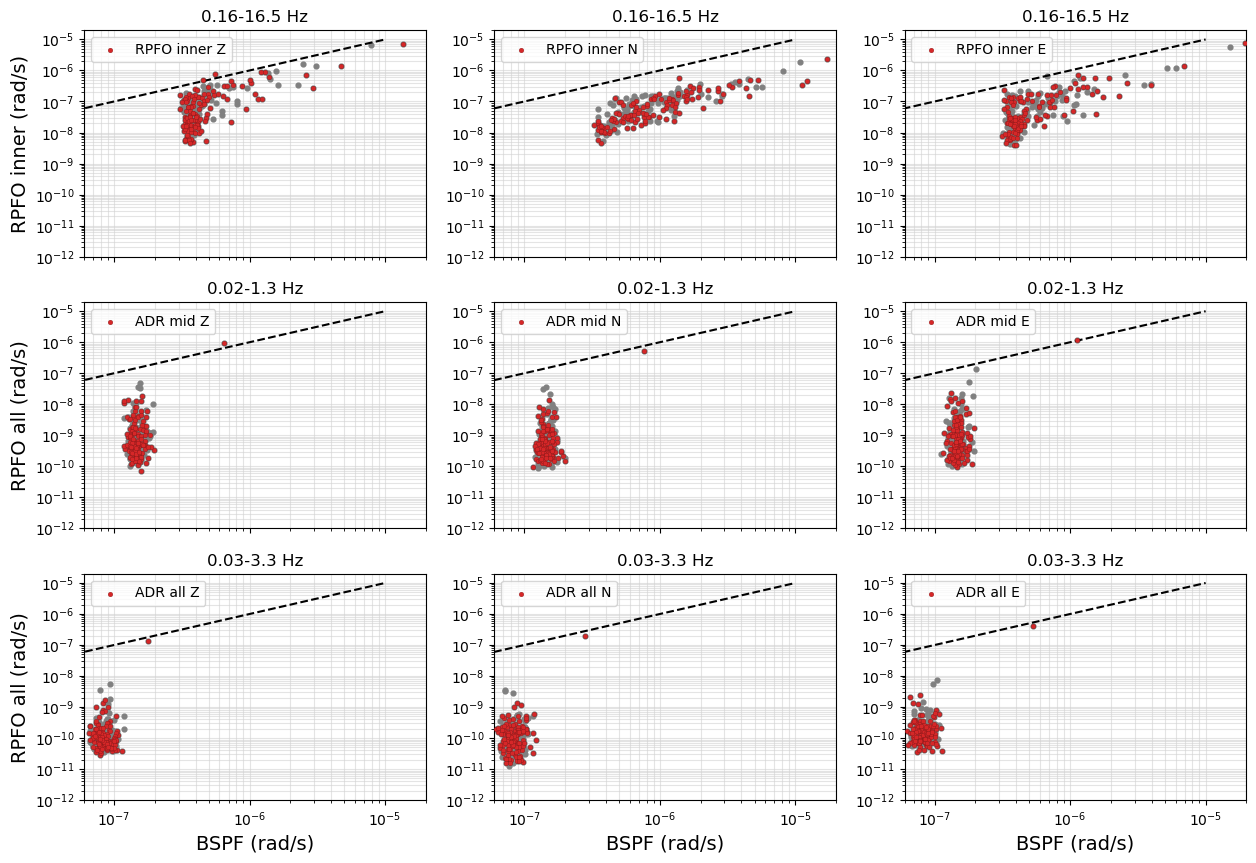

In [19]:
fig = __makeplot_compare_amax(data_adr, data_adr_cosum_6)

fig.savefig(config['path_to_figs']+f"BSPF_statistics_amplitude_comparison_ADR_BSPF.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Signal-to-Noise Ratio

In [20]:
data_snr

,Torigin,Magnitude,CoincidenceSum,Mag_type,BAZ,Edistance_km,Hdistance_km,origin,BSPF__E_snr,BSPF__N_snr,...,PFO_10_Z_snr,RPFO_al_E_snr,RPFO_al_N_snr,RPFO_al_Z_snr,RPFO_in_E_snr,RPFO_in_N_snr,RPFO_in_Z_snr,RPFO_mi_E_snr,RPFO_mi_N_snr,RPFO_mi_Z_snr
0,2022-10-01 05:36:11.240,1.13,4.0,ml,199.712618,14.252022,16.920240,2022-10-01 05:36:11.240,1.050654,1.283218,...,121.227113,21.393120,14.518456,27.606632,125.930653,79.846528,156.267027,39.208421,20.714981,31.002105
1,2022-10-02 03:25:16.440,1.49,6.0,ml,199.394033,14.850966,16.887652,2022-10-02 03:25:16.440,2.446143,3.410614,...,296.149223,80.993351,53.965693,77.093485,148.054111,187.272736,587.605685,146.332235,100.880648,188.801345
2,2022-10-02 15:51:37.180,1.68,6.0,ml,159.749086,15.423592,17.486703,2022-10-02 15:51:37.180,1.385612,1.420306,...,236.000732,55.943910,35.293679,112.826179,175.877299,107.054579,363.879275,149.219140,70.385847,149.245007
3,2022-10-02 21:52:54.280,0.99,6.0,ml,199.820062,14.772415,17.645021,2022-10-02 21:52:54.280,1.191715,1.493261,...,63.340601,13.468870,19.788679,51.420401,54.282684,62.945612,97.064172,27.165935,27.291772,42.770727
4,2022-10-04 22:33:48.370,1.00,6.0,ml,198.791501,14.250442,17.443586,2022-10-04 22:33:48.370,1.188840,1.498584,...,41.980985,8.300429,11.246752,35.254708,83.117215,87.697066,68.398361,20.419309,16.835529,15.271732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2023-09-19 16:59:23.750,1.58,6.0,ml,277.552483,25.304601,28.958060,2023-09-19 16:59:23.750,1.555697,2.056979,...,1.221739,10.271595,14.018288,10.863892,46.609092,54.339949,7.871007,16.237082,24.176850,15.779177
221,2023-09-19 18:17:24.190,1.45,4.0,ml,212.629455,19.262266,21.355170,2023-09-19 18:17:24.190,1.272335,1.605279,...,1.194863,10.443141,13.014502,22.518585,50.059537,35.974849,29.707812,16.895555,22.198118,25.282321
222,2023-09-21 01:58:24.210,0.68,6.0,ml,179.675029,7.188470,8.682799,2023-09-21 01:58:24.210,1.054996,1.338743,...,1.067607,2.158105,4.089820,2.251446,4.753527,16.406935,1.461233,2.435447,6.327932,1.422427
223,2023-09-27 13:41:07.510,1.18,6.0,ml,216.668239,15.777807,20.719655,2023-09-27 13:41:07.510,1.152364,1.374413,...,1.073147,7.502305,2.862174,4.602962,37.188665,24.109099,12.283698,17.662734,6.844072,10.313032


In [21]:
# pd.plotting.scatter_matrix(data_snr[['Magnitude','CoincidenceSum','BAZ','Edistance_km','Hdistance_km']], alpha=0.2, figsize=(10,10))
# plt.show();

In [22]:
# pd.plotting.scatter_matrix(data_amax[['BSPF__Z_amax','BSPF__N_amax','BSPF__E_amax','RPFO_al_Z_amax','RPFO_al_N_amax','RPFO_al_E_amax']], alpha=0.2, figsize=(10,10))
# plt.show();

In [53]:
def __makeplot_snr(data1, data2, xvalue):

    NJ = 5
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15, 10), sharey=True, sharex=True)

    font = 14
    scale = 1e0
    msize = 12

    plt.subplots_adjust(hspace=0.1, wspace=0.05)

    ## _________________________

    ax[0,0].scatter(data1[xvalue], data1.PFO_10_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[0,0].scatter(data2[xvalue], data2.PFO_10_Z_snr*scale, s=msize, label="PFO Z", edgecolor="k", lw=0.5, color="tab:red")

    ax[0,1].scatter(data1[xvalue], data1.PFO_10_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[0,1].scatter(data2[xvalue], data2.PFO_10_N_snr*scale, s=msize, label="PFO N", edgecolor="k", lw=0.5, color="tab:red")

    ax[0,2].scatter(data1[xvalue], data1.PFO_10_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[0,2].scatter(data2[xvalue], data2.PFO_10_E_snr*scale, s=msize, label="PFO E", edgecolor="k", lw=0.5, color="tab:red")

    ## _________________________

    ax[1,0].scatter(data1[xvalue], data1.RPFO_al_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[1,0].scatter(data2[xvalue], data2.RPFO_al_Z_snr*scale, s=msize, label="ADR all Z", edgecolor="k", lw=0.5, color="tab:red")

    ax[1,1].scatter(data1[xvalue], data1.RPFO_al_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[1,1].scatter(data2[xvalue], data2.RPFO_al_N_snr*scale, s=msize, label="ADR all N", edgecolor="k", lw=0.5, color="tab:red")

    ax[1,2].scatter(data1[xvalue], data1.RPFO_al_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[1,2].scatter(data2[xvalue], data2.RPFO_al_E_snr*scale, s=msize, label="ADR all E", edgecolor="k", lw=0.5, color="tab:red")

    ## _________________________

    ax[2,0].scatter(data1[xvalue], data1.RPFO_mi_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[2,0].scatter(data2[xvalue], data2.RPFO_mi_Z_snr*scale, s=msize, label="ADR mid Z", edgecolor="k", lw=0.5, color="tab:red")

    ax[2,1].scatter(data1[xvalue], data1.RPFO_mi_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[2,1].scatter(data2[xvalue], data2.RPFO_mi_N_snr*scale, s=msize, label="ADR mid N", edgecolor="k", lw=0.5, color="tab:red")

    ax[2,2].scatter(data1[xvalue], data1.RPFO_mi_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[2,2].scatter(data2[xvalue], data2.RPFO_mi_E_snr*scale, s=msize, label="ADR mid E", edgecolor="k", lw=0.5, color="tab:red")

    ## _________________________

    ax[3,0].scatter(data1[xvalue], data1.RPFO_in_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[3,0].scatter(data2[xvalue], data2.RPFO_in_Z_snr*scale, s=msize, label="ADR inner Z", edgecolor="k", lw=0.5, color="tab:red")

    ax[3,1].scatter(data1[xvalue], data1.RPFO_in_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[3,1].scatter(data2[xvalue], data2.RPFO_in_N_snr*scale, s=msize, label="ADR inner N", edgecolor="k", lw=0.5, color="tab:red")

    ax[3,2].scatter(data1[xvalue], data1.RPFO_in_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[3,2].scatter(data2[xvalue], data2.RPFO_in_E_snr*scale, s=msize, label="ADR inner E", edgecolor="k", lw=0.5, color="tab:red")

    ## _________________________

    ax[4,0].scatter(data1[xvalue], data1.BSPF__Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[4,0].scatter(data2[xvalue], data2.BSPF__Z_snr*scale, s=msize, label="BSPF Z", edgecolor="k", lw=0.5, color="tab:red")

    ax[4,1].scatter(data1[xvalue], data1.BSPF__N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[4,1].scatter(data2[xvalue], data2.BSPF__N_snr*scale, s=msize, label="BSPF N", edgecolor="k", lw=0.5, color="tab:red")

    ax[4,2].scatter(data1[xvalue], data1.BSPF__E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[4,2].scatter(data2[xvalue], data2.BSPF__E_snr*scale, s=msize, label="BSPF E", edgecolor="k", lw=0.5, color="tab:red")


    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            # ax[i,j].set_xscale("log")
            ax[i,j].legend(loc=2)
            ax[4,j].set_xlabel(xvalue, fontsize=font)
            ax[i,j].set_ylim(1e-1, 1e4)
            ax[i,j].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0,0].set_ylabel(r"SNR", fontsize=font)
    ax[1,0].set_ylabel(r"SNR", fontsize=font)
    ax[2,0].set_ylabel(r"SNR", fontsize=font)
    ax[3,0].set_ylabel(r"SNR", fontsize=font)
    ax[4,0].set_ylabel(r"SNR", fontsize=font)

    plt.show()
    return fig

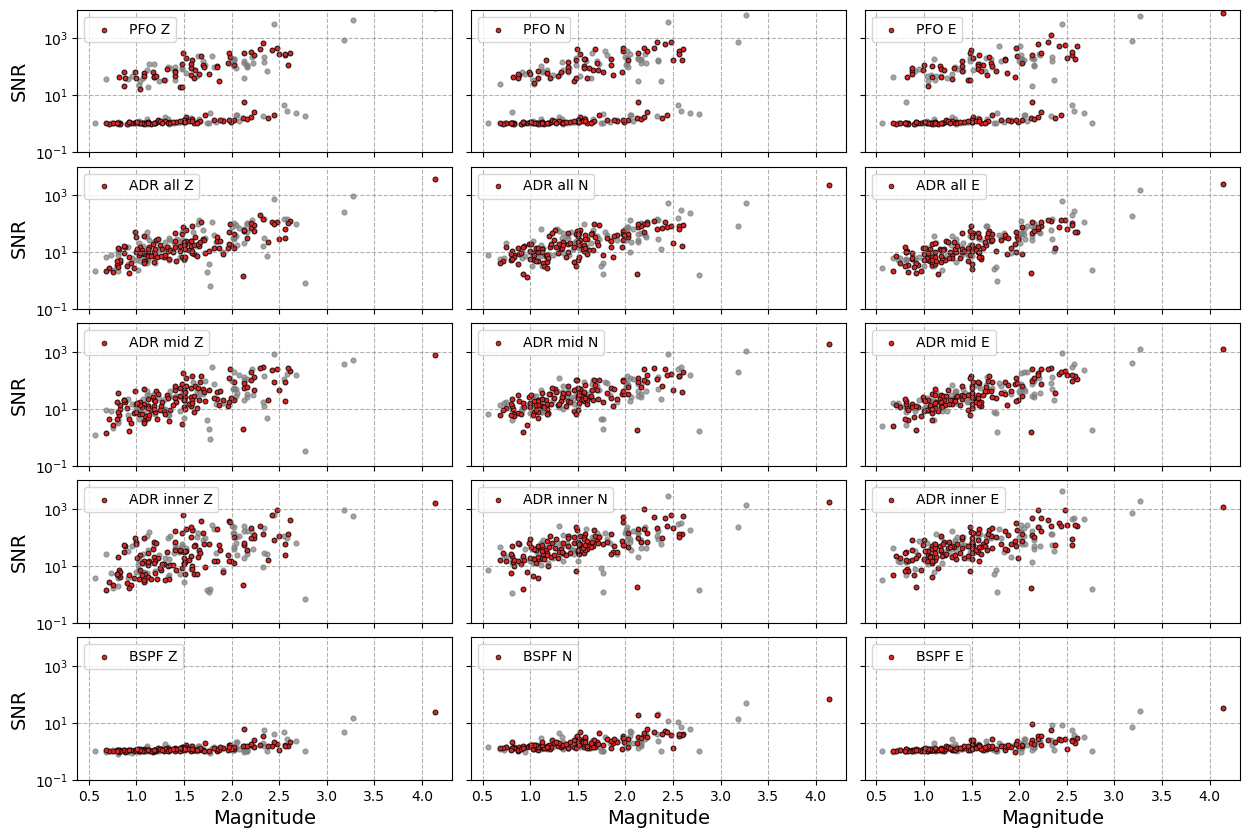

In [54]:
fig = __makeplot_snr(data_snr, data_snr_cosum_6, "Magnitude")

fig.savefig(config['path_to_figs']+f"BSPF_statistics_snr_magnitude.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Velocity

In [55]:
from functions.compute_linear_regression import __compute_linear_regression

In [56]:
def __makeplot_velocity(data):

    from numpy import array, log10

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    font = 14

    scale = 1e3
    msize = 10
    linew = 0.3

    data0 = data.dropna()

    x_arr1 = data0.BSPF__Z_amax*scale
    y_arr1= 0.5*data0.PFO_10_T_amax*scale

    xx1 = array([b for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])
    yy1 = array([a for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])

#     xx1, yy1 = log10(xx1), log10(yy1)

    x_axis1 = np.linspace(0, xx1.max(), 100)


    ## linear regression
#     b1, a1 = __compute_orthogonal_distance_regression(xx1, yy1, xerr=None, yerr=None, bx=None, by=None)
    b1, a1 = __compute_linear_regression(xx1, yy1, intercept_is_zero=True)

    ax[0].scatter(xx1, yy1, s=20, c='r', marker="o", label=f"N={len(xx1)}", zorder=3, lw=linew, edgecolors="k")
    ax[0].plot(x_axis1, a1+b1*x_axis1, color='k', ls="--", label=f"f(x) = {a1:.0f} + {b1:.0f} x", zorder=1)

    ax[0].legend(loc=2, fontsize=font)
    ax[0].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0].set_xlim(left=0)
    ax[0].set_ylim(bottom=0)

    ax[0].set_xlabel("vertical rotation rate $\Omega_Z$ (mrad/s)", fontsize=font)
    ax[0].set_ylabel("transverse acceleration $a_T$ (mm/s$^2$)", fontsize=font)
    ax[0].set_title("Love Phase Velocity", fontsize=font+1)


    ## ______________________________________________

    x_arr2 = data0.BSPF__T_amax*scale
    y_arr2= data0.PFO_10_Z_amax*scale

    xx2 = array([b for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])
    yy2 = array([a for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])

#     xx2, yy2 = log10(xx2), log10(yy2)

    x_axis2 = np.linspace(0, xx2.max(), 100)

    ## linear regression
#     b2, a2 = __compute_orthogonal_distance_regression(xx2, yy2, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_linear_regression(xx2, yy2, intercept_is_zero=True)

    ax[1].scatter(xx2, yy2, s=20, c='r' ,marker="o", label=f"N={len(xx2)}", zorder=3, lw=linew, edgecolors="k")
    ax[1].plot(x_axis2, a2+b2*x_axis2, color='k', ls="--", label=f"f(x) = {a2:.0f} + {b2:.0f} x", zorder=1)

    ax[1].legend(loc=2, fontsize=font)
    ax[1].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[1].set_xlim(left=0)
    ax[1].set_ylim(bottom=0)

    ax[1].set_xlabel("transverse rotation rate $\Omega_T$ (mrad/s)", fontsize=font)
    ax[1].set_ylabel("vertical acceleration $a_Z$ (mm/s$^2$)", fontsize=font)
    ax[1].set_title("Rayleigh Phase Velocity", fontsize=font+1)

    plt.show();
    return fig

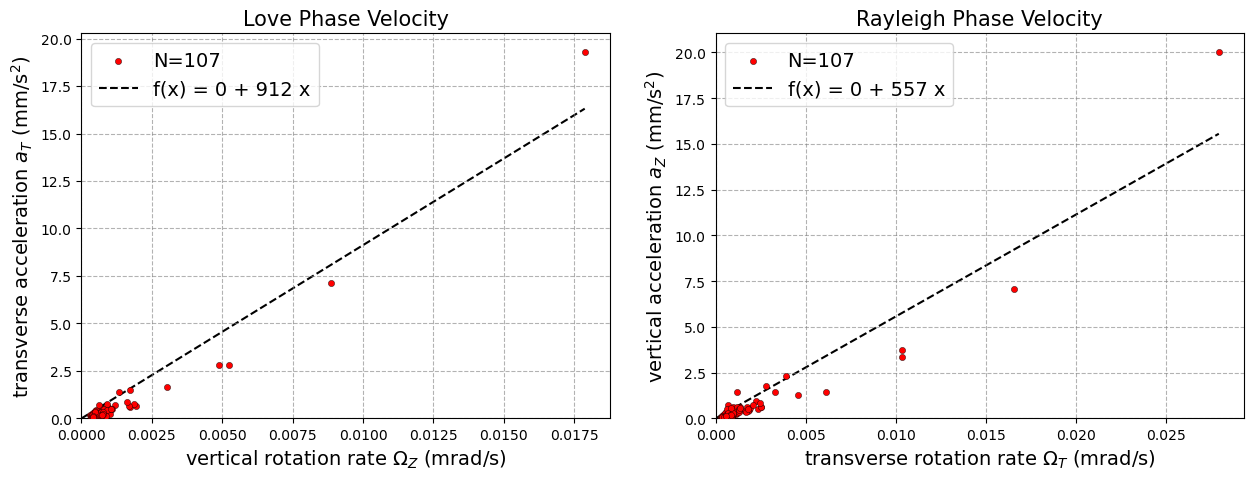

In [57]:
__makeplot_velocity(data_amax)

fig.savefig(config['path_to_figs']+f"BSPF_statistics_velocity_from_Amax.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

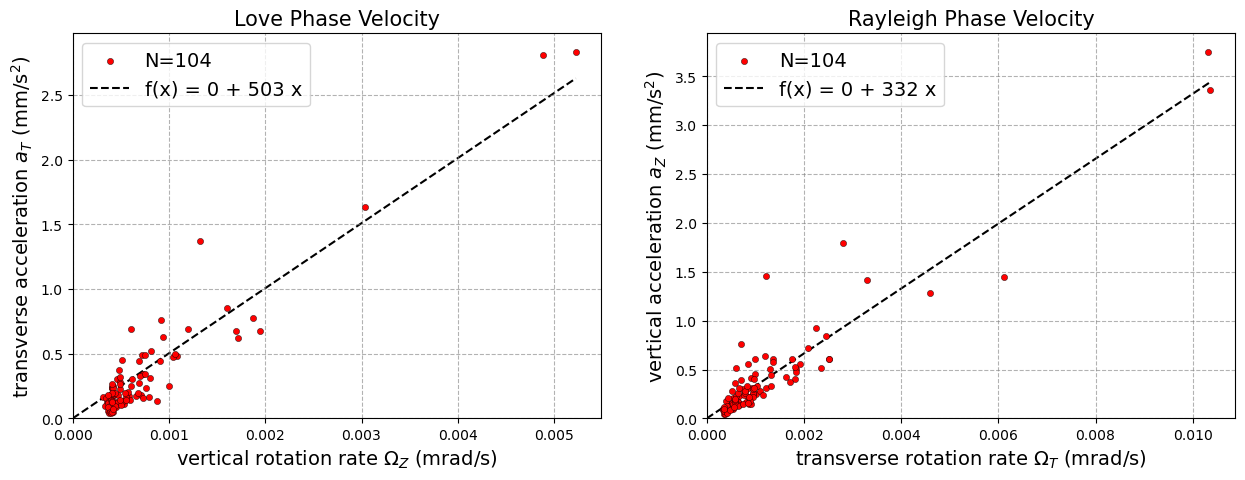

In [63]:
__makeplot_velocity(data_amax[data_amax.Magnitude < 3])

fig.savefig(config['path_to_figs']+f"BSPF_statistics_velocity_from_Amax_M<3.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

In [111]:
def __makeplot_velocity_multiple(data, odr=False):

    from numpy import array, log10

    def __regress1(data, scale):
        data0 = data.dropna()

        x_arr1 = data0.BSPF__Z_amax*scale
        y_arr1= 0.5*data0.PFO_10_T_amax*scale

        xx1 = array([b for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])
        yy1 = array([a for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])

        x_axis1 = np.linspace(0, xx1.max(), 100)

        ## linear regression
        if odr:
            b1, a1 = __compute_orthogonal_distance_regression(xx1, yy1, xerr=None, yerr=None, bx=None, by=None)
        else:
            b1, a1 = __compute_linear_regression(xx1, yy1, intercept_is_zero=True)

        return x_axis1, b1, a1

    scale = 1e3

    data0 = data.dropna()

    x_arr1 = data0.BSPF__Z_amax*scale
    y_arr1= 0.5*data0.PFO_10_T_amax*scale

    xx1 = array([b for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])
    yy1 = array([a for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    font = 14

    msize = 10
    linew = 0.3

    ax[0].scatter(xx1, yy1, s=20, c='r', marker="o", label=f"N={len(xx1)}", zorder=3, lw=linew, edgecolors="k")

    x_axis1, b1, a1 = __regress1(data[data.Magnitude > 0], scale)
    ax[0].plot(x_axis1, a1+b1*x_axis1, color='k', ls="--", label=f"f(x) = {a1:.0f} + {b1:.0f} x  (M>0)", zorder=1)

    x_axis1, b1, a1 = __regress1(data[data.Magnitude < 3], scale)
    ax[0].plot(x_axis1, a1+b1*x_axis1, color='b', ls="--", label=f"f(x) = {a1:.0f} + {b1:.0f} x  (M<3)", zorder=1)

    ax[0].legend(loc=2, fontsize=font)
    ax[0].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0].set_xlim(left=0)
    ax[0].set_ylim(bottom=0)

    ax[0].set_xlabel("vertical rotation rate $\Omega_Z$ (mrad/s)", fontsize=font)
    ax[0].set_ylabel("transverse acceleration $a_T$ (mm/s$^2$)", fontsize=font)
    ax[0].set_title("Love Phase Velocity", fontsize=font+1)


    ## ______________________________________________

    def __regress2(data, scale):
        data0 = data.dropna()

        x_arr2 = data0.BSPF__T_amax*scale
        y_arr2= data0.PFO_10_Z_amax*scale

        xx2 = array([b for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])
        yy2 = array([a for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])

        x_axis2 = np.linspace(0, xx2.max(), 100)

        ## linear regression
        if odr:
            b2, a2 = __compute_orthogonal_distance_regression(xx2, yy2, xerr=None, yerr=None, bx=None, by=None)
        else:
            b2, a2 = __compute_linear_regression(xx2, yy2, intercept_is_zero=True)

        return x_axis2, b2, a2 

    x_arr2 = data0.BSPF__T_amax*scale
    y_arr2= data0.PFO_10_Z_amax*scale

    xx2 = array([b for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])
    yy2 = array([a for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])

    x_axis2 = np.linspace(0, xx2.max(), 100)


    ax[1].scatter(xx2, yy2, s=20, c='r' ,marker="o", label=f"N={len(xx2)}", zorder=3, lw=linew, edgecolors="k")

    x_axis2, b2, a2 = __regress2(data[data.Magnitude > 0], scale)
    ax[1].plot(x_axis2, a2+b2*x_axis2, color='k', ls="--", label=f"f(x) = {a2:.0f} + {b2:.0f} x", zorder=1)

    x_axis2, b2, a2 = __regress2(data[data.Magnitude < 3], scale)
    ax[1].plot(x_axis2, a2+b2*x_axis2, color='b', ls="--", label=f"f(x) = {a2:.0f} + {b2:.0f} x", zorder=1)


    ax[1].legend(loc=2, fontsize=font)
    ax[1].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[1].set_xlim(left=0)
    ax[1].set_ylim(bottom=0)

    ax[1].set_xlabel("transverse rotation rate $\Omega_T$ (mrad/s)", fontsize=font)
    ax[1].set_ylabel("vertical acceleration $a_Z$ (mm/s$^2$)", fontsize=font)
    ax[1].set_title("Rayleigh Phase Velocity", fontsize=font+1)

    plt.show();
    return fig

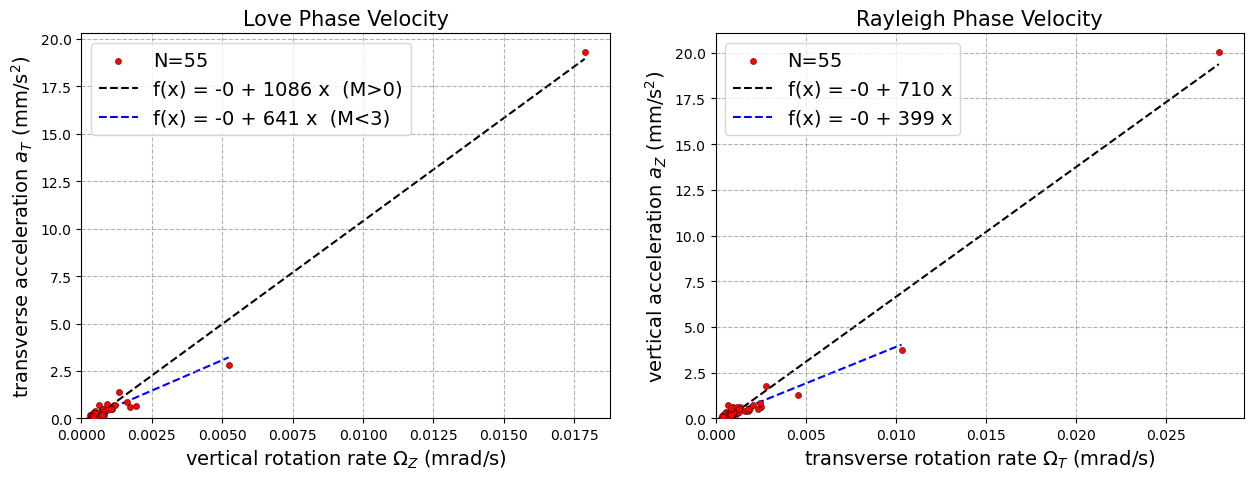

In [113]:
fig = __makeplot_velocity_multiple(data_amax_cosum_6, odr=False);

fig.savefig(config['path_to_figs']+f"BSPF_statistics_velocity_multiple_lin.png", dpi=200, bbox_inches='tight', pad_inches=0.05);